# Lecture 6

## Two-dimensional spatial domain

We will now consider equations within a simple two-dimensional spatial domain. To get started we will look at the Poisson equation

$$
\nabla^2 u = f
$$

which in two-dimensional Cartesian coordinates is

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f
$$

We consider the equation for a rectangular domain

$$(x, y) \in [0, L_x] \times [0, L_y]$$

and Dirichlet boundary conditions. A Dirichlet boundary condition means that the solution is known (or fixed) at the boundary. There are now 4 sides to a rectangle and the solutions needs to be fixed at all these boundaries since there are two derivatives in both $x$ and $y$ directions. We need to fix: 

$$\color{red}{ u(x=0, y)}, \quad \color{green}{u(x=L_x, y)}$$
$$\color{blue}{u(x, y=0)}, \quad \color{magenta}{u(x, y=L_y)}$$ 

In the figure below the location of these Dirichlet conditions are plotted in color. 

Note that the conditions at the two sides $x=0$ and $x=L_x$ can be functions of the other coordinate $y$. Likewise, for the two boundaries with constant $y$ the condition may be a function of $x$. Also note that the boundary conditions need to be consistent in the corners, because each corner belongs to two sides.


We will at first simply use a constant value 0 along all boundaries since this is easiest. In that case 

$$u(x=0, y) = u(x=L_x, y) = u(x, y=0) = u(x, y=L_y) = 0$$


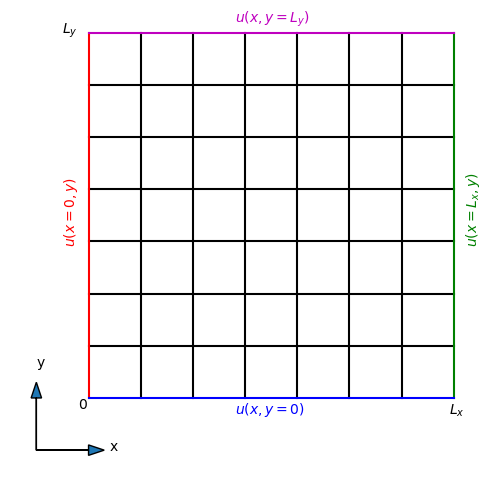

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))
N = 8
for i in range(1, N-1):
    plt.plot((0, N-1), (i, i), 'k')
for j in range(1, N-1):
    plt.plot((j, j), (0, N-1), 'k')
plt.plot((0, 0), (0, N-1), 'r')
plt.plot((N-1, N-1), (0, N-1), 'g')
plt.plot((0, N-1), (0, 0), 'b')
plt.plot((0, N-1), (N-1, N-1), 'm')
plt.arrow(-1, -1, 1, 0, head_width=0.2)
plt.arrow(-1, -1, 0, 1, head_width=0.2)
plt.text(0.4, -1, "x")
plt.text(-1, 0.6, "y")
plt.text(-0.2, -0.2, "$0$")
plt.text(N-1.1, -0.3, "$L_x$")
plt.text(-0.5, N-1, "$L_y$")
plt.text(N-1+0.2, (N-1)/2-0.5, "${u(x=L_x, y)}$", color='g', rotation='vertical')
plt.text(-0.5, (N-1)/2-0.5, "${u(x=0, y)}$", color='r', rotation='vertical')
plt.text((N-1)/2-0.7, -0.3, "${u(x, y=0)}$", color='b')
plt.text((N-1)/2-0.7, N-1+0.2, "${u(x, y=L_y)}$", color='m')
ax = fig.gca()
ax.axis('off')
ax.axis('equal');

## Discretization

We discretize the mesh using two lines, one in the $x$-direction and one in the $y$-direction:

$$
x_i = i \Delta x, \quad i = 0, 1, \ldots, N_x
$$

$$
y_j = j \Delta y, \quad j = 0, 1, \ldots, N_y
$$

where $\Delta x = L_x/N_x$ and $\Delta y = L_y/N_y$. The mesh is plotted above for $N_x=N_y = 8$. We will use vector notation for the mesh, with

$$
\boldsymbol{x} = \{x_0, x_1, \ldots, x_{N_x}\}
$$
$$
\boldsymbol{y} = \{y_0, y_1, \ldots, y_{N_y}\}
$$



### Cartesian products

In order to create a two-dimensional mesh, like the one seen above, we use a Cartesian product. The Cartesian product is most easily explained through an example. Consider the two arrays $\boldsymbol{u}=[1, 2, 3]$ and $\boldsymbol{v}=[4, 5]$. We can compute the Cartesian product of these two arrays using the Python package [itertools](https://docs.python.org/3/library/itertools.html)

In [2]:
import itertools
u = np.array([1, 2, 3])
v = np.array([4, 5])
uxv = itertools.product(u, v)
list(uxv)

[(1, 4), (1, 5), (2, 4), (2, 5), (3, 4), (3, 5)]

So we get a list containing all possible pairs of items, one from $\boldsymbol{u}$ and one from $\boldsymbol{v}$. Since there are 3 items in $\boldsymbol{u}$ and 2 in $\boldsymbol{v}$ we get a total of $2 \cdot 3 = 6$ pairs of numbers. 

The Cartesian product $\boldsymbol{u} \times \boldsymbol{v}$ can be described mathematically as

$$
\boldsymbol{u} \times \boldsymbol{v} = \{ (u, v) \, | \,  u \in \boldsymbol{u} \text{ and } v \in \boldsymbol{v} \} 
$$

which reads all the pairs $(u, v)$ such that $u$ is in the set $\boldsymbol{u}$ and $v$ in the set $\boldsymbol{v}$.

What does this have to do with a discretization of a computational mesh? Well the computational mesh is a combination of all pairs $(x, y)$ such that $x$ is in the 1D mesh along the $x$-direction ($0, \Delta x, 2 \Delta x, \ldots$) and $y$ is in the 1D mesh along the $y$-direction ($0, \Delta y, 2 \Delta y, \ldots$). We have already defined these two meshes above in the vectors $\boldsymbol{x}$ and $\boldsymbol{y}$. So the computational mesh is really

$$
\boldsymbol{x} \times \boldsymbol{y} = \{(x, y) \, | \, x \in \boldsymbol{x} \text{ and } y \in \boldsymbol{y} \}
$$

all pairs $(x, y)$ such that $x$ is in $\boldsymbol{x}$ and $y$ is in $\boldsymbol{y}$.

If the meshes are simply

$$
\boldsymbol{x} = \{0, \Delta x, 2\Delta x, 3\Delta x\}  \text{ and } \boldsymbol{y} = \{0, \Delta y, 2\Delta y\}
$$

then a two-dimensional mesh would be all possible combinations of these arrays, as shown below.

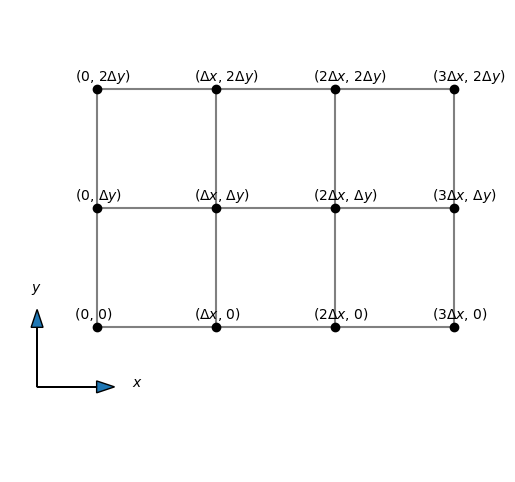

In [3]:
fig = plt.figure(figsize=(6, 6))
for i in range(3):
    plt.plot((0, 3), (i, i), 'grey')
for j in range(4):
    plt.plot((j, j), (0, 2), 'grey')

Dx = {0: '0', 1: '$\Delta x$', 2: '$2 \Delta x$', 3: '$3\Delta x$' }
Dy = {0: '0', 1: '$\Delta y$', 2: '$2 \Delta y$', 3: '$3\Delta y$' }
for i in range(4):
    for j in range(3):
        plt.plot(i, j, 'ko')
        plt.text(i-0.18, j+0.07, f'({Dx[i]}, {Dy[j]})')
plt.arrow(-0.5, -0.5, 0.5, 0, head_width=0.1)
plt.arrow(-0.5, -0.5, 0, 0.5, head_width=0.1) 
plt.text(0.3, -0.5, '$x$')
plt.text(-0.55, 0.3, '$y$')
ax = fig.gca()
ax.axis('off')
ax.axis('equal');

Note that there are $4 \cdot 3 = 12$ pairs of numbers. If we drop $\Delta x$ and $\Delta y$ from the pairs and use only the integers in front of them, we get with itertools:

In [4]:
xy = list(itertools.product([0, 1, 2, 3], [0, 1, 2]))
print(xy)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]


We see that itertools (or the Cartesian product) presents the result as an array of pairs of length $12$ (12 pairs). It does not shape the product in a Cartesian two-dimensional mesh.

However, when we illustrate these numbers in a Cartesian mesh, then we see that it is only natural to use two-dimensional arrays.

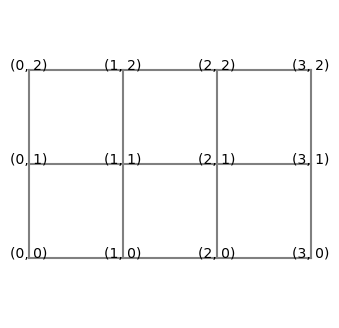

In [5]:
fig = plt.figure(figsize=(4, 4))
for i in range(3):
    plt.plot((0, 3), (i, i), 'grey')
for j in range(4):
    plt.plot((j, j), (0, 2), 'grey')
for m in xy:
    plt.text(m[0], m[1], f'({m[0]}, {m[1]})', horizontalalignment='center')
        
ax = fig.gca()
ax.axis('off')
ax.axis('equal');

Note that if this mesh was a two-dimensional matrix, then $i$ and $j$ in $(i, j)$ would represent column and row, respectively, which is counterintuitive. We normally think about a matrix $A$ with items $a_{ij}$, where the first index $i$ represents row and the second index $j$ represents column. This is a complicating factor for the Cartesian mesh that is important to be aware of. But it is not a mistake. The numbers in the plot above are not indices of a matrix, they represent $(x, y)$ in a Cartesian mesh.

### meshgrid

The Cartesian mesh gives both $x$ and $y$ coordinates for the entire two-dimensional mesh and it is created from a Cartesian product of one-dimensional meshes along $x$ and $y$-directions. Luckily for us Numpy has a function that computes this mesh for us and we do not have to use itertools directly.

Let us now compute the Cartesian mesh for 

$$
\boldsymbol{x} = [0, 1, 2, 3] \quad \text{ and } \quad
\boldsymbol{y} = [0, 1, 2]
$$

where we have chosen $\Delta x = \Delta y = 1$ just for simplicity.

We create this 2D mesh using [numpy.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)

In [6]:
Nx = 3
Ny = 2
Lx = Nx
Ly = Ny
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
mesh = np.meshgrid(x, y, indexing='ij')

At this point `mesh` will actually contain two arrays and we extract them by

In [7]:
xij, yij = mesh

Now `xij` will contain the $x$-coordinates of all nodes in the mesh, and `yij` will contain all $y$-coordinates. Numpy has split up the coordinate pair for all points and put the result into these two arrays. Let us take a look at `xij` and `yij`

In [8]:
xij

array([[0., 0., 0.],
       [1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.]])

In [9]:
yij

array([[0., 1., 2.],
       [0., 1., 2.],
       [0., 1., 2.],
       [0., 1., 2.]])

Hmmm. These arrays seem to be aligned very differently from the mesh that we have been looking at so far. `xij` has shape $4 \times 3$ and the $x$ value increases along a column. Likewise, the `yij` array has also shape $4 \times 3$, and the $y$-value increases along a row. So the ordering is as the following arrows show

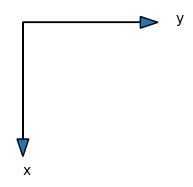

In [10]:
fig = plt.figure(figsize=(2, 2))
plt.arrow(0, 0, 1, 0, head_width=0.1);plt.text(0, -1.3, 'x')
plt.arrow(0, 0, 0, -1, head_width=0.1);plt.text(1.3, 0, 'y')
fig.gca().axis('off');

This is opposite to a Cartesian mesh that has $x$ varying along the horizontal direction and $y$ varying along the vertical direction:

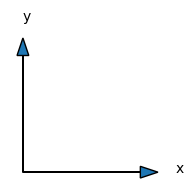

In [11]:
fig = plt.figure(figsize=(2, 2))
plt.arrow(0, 0, 1, 0, head_width=0.1);plt.text(1.3, 0, 'x')
plt.arrow(0, 0, 0, 1, head_width=0.1);plt.text(0, 1.3, 'y')
fig.gca().axis('off');

However, there is no mistake. This is how matrices are stored, with the first index $i$ representing $x$ and the second index $j$ representing $y$. And if we make contour plots using the meshes `xij` and `yij` it all comes out in a Cartesian plot exactly as expected. Below we create contour plots of both $x$ and $y$ and we notice that $x$ increases along the horizontal axis, whereas $y$ increases in the vertical direction. Just as expected:-)

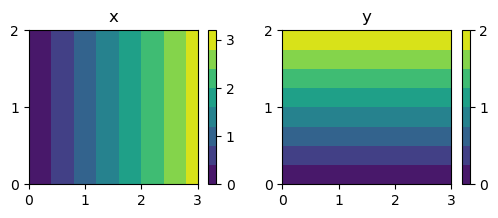

In [12]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(6, 2))
c0 = ax0.contourf(xij, yij, xij)
c1 = ax1.contourf(xij, yij, yij)
ax0.set_title('x');
ax1.set_title('y');
ax0.set_yticks([0, 1, 2])
ax1.set_yticks([0, 1, 2])
fig.colorbar(c0, ticks=[0, 1, 2, 3]);
fig.colorbar(c1, ticks=[0, 1, 2]);

### Two-dimensional mesh function

A mesh function on the two-dimensional domain will now be denoted as

$$
u_{ij} = u(x_i, y_j)
$$

The mesh function is a dense two-dimensional array of shape ${(N_x+1)\times (N_y+1)}$ and we will write $U = (u_{ij})_{i,j=0}^{N_x, N_y}$. It may also be considered a matrix.

$$
\begin{bmatrix}
u_{0, 0} & u_{0, 1} & \cdots & u_{0, N_y} \\
u_{1, 0} & u_{1, 1} & \cdots & u_{1, N_y} \\
\vdots & \vdots & \ddots & \vdots \\
u_{N_x, 0} & u_{N_x, 1} & \cdots & u_{N_x, N_y} \\
\end{bmatrix}
$$

We note that the mesh function $U$ is a matrix, like `xij` and `yij`, and in the component $u_{ij}$ $i$ represents row and $j$ represents column. 

Also note that sometimes (like above) it makes sense to add a comma between $i$ and $j$. This has no further significance than to more clearly seperate $i$ from $j$.

```{note}
Notice that both `xij` and `yij` are mesh functions! They are the coordinates `x` and `y` evaluated on the computational mesh.
```

### Row-major computer storage 

In Python (which is written in C) a matrix is row-major. This means that the matrix is stored in memory with a long sequence of numbers row by row like

$$
\Big( \underbrace{u_{0, 0}, u_{0, 1}, \cdots, u_{0, N_y}}_{\text{First row}}, \underbrace{u_{1, 0}, u_{1, 1}, \cdots, u_{1, N_y}}_{\text{Second row}}, \cdots \cdots, \underbrace{u_{N_y, 0}, u_{N_y, 1}, \cdots, u_{N_y, N_y}}_{\text{Last row}} \Big)
$$

So the computer memory does not know anything about these numbers belonging to a two-dimensional array. The computer only knows that $(N_x+1)(N_y+1)$ numbers are stored side by side.

We can get the single row $i$ of the $U$ matrix as $u_i = (u_{i,0}, u_{i,1}, \ldots, u_{i, N_y})$. For example, lets create a $3 \times 3$ matrix  in Python

In [13]:
A = np.arange(9).reshape((3, 3))
A

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

The matrix `A` is laid out in computer memory as

In [14]:
A.ravel() # alternative: A.flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

This is row-major storage. First the first row, then the second row and finally the third. We can easily get individual rows of `A` as, e.g., 

In [15]:
A[1]

array([3, 4, 5])

In [16]:
A[2]

array([6, 7, 8])

We get the rows easily because the memory is row-major and all the items in a row are side by side in computer memory. However, in order to get a column we need to skip over items. The first column of `A` contains the numbers `[0, 3, 6]`. These numbers are stored in the flattened memory as items 0, 3 and 6. We can look it up as

In [17]:
A[:, 0]

array([0, 3, 6])

## Finite differences in 2D

Let us move back to the Poisson equation

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f
$$

If we now use second order central differences in both directions we get

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1, j}}{\Delta x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i, j-1}}{\Delta y^2} = f_{i,j}
$$

We have already learned that a second differentiation matrix in one dimension can be written as

$$
D_x^{(2)} = \frac{1}{\Delta x^2}\begin{bmatrix}
2 & -5 & 4 & -1  & 0 & 0 & 0 & 0  \\
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots \\
0 & 1 & -2 & 1 & 0 & 0 & 0 & \cdots \\
\vdots & & & \ddots &  & & &\cdots \\
\vdots & 0 & 0 & 0 &  1& -2& 1& 0 \\
\vdots & 0 & 0& 0& 0& 1& -2& 1 \\
0 & 0 & 0 & 0  & -1 & 4 & -5 & 2 \\
\end{bmatrix}
$$

For the $y$-direction we will use $ \Delta y$ instead of $\Delta x$ and we will then write $D^{(2)}_y$. 

```{note}
We will denote the unscaled second derivative matrix $D^{(2)}$. This is the matrix you get with $\Delta x = \Delta y = 1$. 
```

We compute the unscaled matrix $D^{(2)}$ as

In [18]:
import scipy.sparse as sparse

def D2(N):
    D = sparse.diags([1, -2, 1], [-1, 0, 1], (N+1, N+1), 'lil')
    D[0, :4] = 2, -5, 4, -1
    D[-1, -4:] = -1, 4, -5, 2
    return D
print(D2(8).toarray()) 

[[ 2. -5.  4. -1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0. -1.  4. -5.  2.]]


Now let us consider a very simple function in 2D

$$
u(x, y) = x^2
$$

such that 

$$
\frac{\partial^2 u}{\partial x^2} = 2
$$

Let the domain now be $[0, 4]\times [0, 4]$ and choose $\Delta x = \Delta y = 1$. We create the Cartesian product mesh as follows


In [19]:
Nx = 4
Ny = 4
Lx = Nx
Ly = Ny
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
xij, yij = np.meshgrid(x, y, indexing='ij')

From this mesh we can create the mesh function $u(x, y) = x^2$

In [20]:
u = xij**2
print(u)

[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  4.  4.  4.  4.]
 [ 9.  9.  9.  9.  9.]
 [16. 16. 16. 16. 16.]]


In order to compute $\partial^2 u/\partial x^2$ we can use the one-dimensional derivative matrix $D^{(2)}$ along the first axis of $U=(u_{i,j})_{i,j=0}^{N_x, N_y}$

$$
D^{(2)} U = \sum_{k=0}^{N_x} d^{(2)}_{ik} u_{k,j}
$$

So $D^{(2)} U $ is a matrix-matrix product between the two matrices $D^{(2)}\in \mathbb{R}^{(N_x+1)\times (N_x+1)}$ and $U \in \mathbb{R}^{(N_x+1) \times (N_y+1)}$, such that $D^{(2)}U \in \mathbb{R}^{(N_x+1) \times (N_y+1)}$

In [21]:
D = D2(Nx)
print(D @ u)

[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]


So we see that the second derivative of $u$ equals 2 in all nodes of the mesh. This means that our code is working:-)

How about the other derivative $\partial^2 u / \partial y^2$? Let us create a mesh function 

$$
u(x, y) = y^2
$$

such that again the second derivative $\partial^2 u / \partial y^2$ should be 2. Create first $u$

In [22]:
u = yij**2
print(u)

[[ 0.  1.  4.  9. 16.]
 [ 0.  1.  4.  9. 16.]
 [ 0.  1.  4.  9. 16.]
 [ 0.  1.  4.  9. 16.]
 [ 0.  1.  4.  9. 16.]]


Now since the derivative is along the second axis (the $y$-axis), we cannot simply do $D^{(2)} U$ anymore. If we do we get zero

In [23]:
print(D @ u)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


because this is $\partial ^2 u/ \partial x^2$, which should be zero. To get a derivative along the second axis we need to apply the matrix $D^{(2)}$ along the second axis of $U$: 

$$
\sum_{k=0}^{N_y} u_{i, k} d^{(2)}_{j, k}
$$

On matrix form this can be written as

$$
U (D^{(2)})^T
$$

which we can verify as follows

In [24]:
print(u @ D.T)

[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]


Again we get the correct result across the entire mesh.

## Matrix form of Poisson's equation

Using now that $\partial^2 u/\partial x^2 = D_x^{(2)}U$ and $\partial^2 u/\partial y^2 = U(D_y^{(2)})^T$ we can write Poisson's equation on discretized (and matrix) form as

$$
D_x^{(2)} U + U (D_y^{(2)})^T = F
$$ (mat-equation)

where the mesh function $F = (f(x_i, y_j))_{i,j=0}^{N_x, N_y}$.

However, how can we solve this equation for the unknown $U$? 

The problem now is that we cannot (apparently) write Eq. {eq}`mat-equation` as we normally do for a linear algebra problem

$$
Ax = b
$$ (Axb)

or on index form

$$
\sum_{j=0}^{N}a_{ij} x_j = b_i
$$ (Axbindex)

where $A$ is the coefficient matrix, $x$ is the unknown vector and $b$ is the right hand side vector.

However, there is an operation that will help us transform {eq}`mat-equation` into a regular matrix problem like {eq}`Axb`. This operation is called vectorization, or the vec-trick.


## Vectorization (the vec-trick)

Consider first for simplicity a  $2 \times 2$ matrix

$$
A = 
\begin{bmatrix}
a & b \\
c & d
\end{bmatrix}
$$

In general, a row-major vectorization transforms the matrix into a vector as follows

$$
\begin{bmatrix}
a & b \\
c & d
\end{bmatrix}
\longrightarrow
\begin{bmatrix}
a & b & c & d
\end{bmatrix}
$$

This operation is referred to as `vec(A)` and thus 

$$
\text{vec}(A) = \begin{bmatrix}
a & b & c & d
\end{bmatrix}
$$

```{warning}
Notice that it is possible to define a column-major vectorization as well. In that case $\text{vec}(A) = [a \, c \, b \, d]$. However, since Python is written in C and C is row-major, we will use the first, row-major, alternative.
```

Vectorization of our Poisson equation (vectorization applied to both left and right hand side) leads to

$$
\text{vec}\left(D_x^{(2)}U + U (D_y^{(2)})^T \right) = \text{vec}(F)
$$

and since vectorization is a linear process

$$
\text{vec}\left(D_x^{(2)}U\right) + \text{vec}\left(U (D_y^{(2)})^T \right) = \text{vec}(F)
$$

Here $\text{vec}(F)$ is simply the ravelling (or flattening) of the matrix as described above. This leaves the left hand side, which contains matrix-matrix products, and these require a special trick for vectorization. But first we will write the equation as 

$$
\text{vec}\left(D_x^{(2)}U I_{y}\right) + \text{vec}\left(I_{x} U (D_y^{(2)})^T \right) = \text{vec}(F)
$$

where the diagonal identity matrix $I_{i} \in \mathbb{R}^{(N_i+1) \times (N_i+1)}$

$$
I_{i} = \begin{bmatrix} 
1 & 0 & 0 & 0 & \cdots \\
0 & 1 & 0 & 0 & \cdots \\
\vdots & & \ddots &  & \cdots \\
\vdots & 0 & 0  & 1 & 0 \\
\vdots & 0 & 0 & 0  & 1
\end{bmatrix}
$$

is not really doing anything. However, it will help us soon in applying a well known vectorization formula for triple matrix products.
It turns out that for any valid triple matrix product of matrices $A, B$ and $C$, vectorization is defined as

$$
\text{vec}(A B C^T) = (A \otimes C) \text{vec} (B)
$$

where $A \otimes B$ is the Kronecker product of matrices $A$ and $B$. We will get back to the Kronecker product soon. Meanwhile we get that

$$
\text{vec}(D_x^{(2)}U I_{y}) = (D_x^{(2)} \otimes I_{y}) \text{vec}(U)
$$

and 

$$
\text{vec}(I_{x} U (D_y^{(2)})^T) = (I_{x} \otimes D_y^{(2)}) \text{vec}(U)
$$

and the equation we need to solve is thus

$$
\left(D_x^{(2)} \otimes I_{y} + I_{x} \otimes D_y^{(2)} \right) \text{vec}(U) = \text{vec}(F)
$$

This is a linear equations of type $Ax=b$, where $A = D_x^{(2)} \otimes I_{y} + I_{x} \otimes D_y^{(2)}$, $x = \text{vec}(U)$ and $b = \text{vec}(F)$.

```{note}
Vectorization is a linear process that allows us to transform a matrix into a vector. Through vectorization we can express matrix-multiplication through a larger matrix using the Kronecker product. 
```

## The Kronecker product

In general, if $A$ and $B$ are matrices of dimensions $p \times q$ and $r \times s$, respectively, then $A \otimes B$ is the matrix
of dimension $pr \times qs$, with $p \times q$ block form, where the $i, j$ block is $a_{ij}B$. The Kronecker product is most simply illustrated for two small matrices of shape $2 \times 2$:

$$
\begin{bmatrix}
  1 & 2 \\
  3 & 4
\end{bmatrix}
\otimes
\begin{bmatrix}
  a & b \\
  c & d
\end{bmatrix}
=
\left(\begin{array}{@{}c|c@{}}
  \begin{matrix}
  a & b \\
  c & d
  \end{matrix}
  &  \begin{matrix}
  2a & 2b \\
  2c & 2d
  \end{matrix} \\
\hline
  \begin{matrix}
  3a & 3b \\
  3c & 3d
  \end{matrix} &
  \begin{matrix}
  4a & 4b \\
  4c & 4d
  \end{matrix}
\end{array}\right)
$$

Notice that if one of the matrices is the identity matrix, the picture becomes even simpler

$$
\begin{bmatrix}
  1 & 0 \\
  0 & 1
\end{bmatrix}
\otimes
\begin{bmatrix}
  a & b \\
  c & d
\end{bmatrix}
=
\left(\begin{array}{@{}c|c@{}}
  \begin{matrix}
  a & b \\
  c & d
  \end{matrix}
  &  
  \begin{matrix}
   0 & 0 \\
   0 & 0 
   \end{matrix}
   \\
\hline
  \begin{matrix}
   0 & 0 \\
   0 & 0 
   \end{matrix} &
  \begin{matrix}
  a & b \\
  c & d
  \end{matrix}
\end{array}\right)
$$

and 

$$
\begin{bmatrix}
  a & b \\
  c & d
\end{bmatrix}
\otimes
\begin{bmatrix}
  1 & 0 \\
  0 & 1
\end{bmatrix}
=
\left(\begin{array}{@{}c|c@{}}
  \begin{matrix}
  a & 0 \\
  0 & a
  \end{matrix}
  &  \begin{matrix}
  b & 0 \\
  0 & b
  \end{matrix} \\
\hline
  \begin{matrix}
  c & 0 \\
  0 & c
  \end{matrix} &
  \begin{matrix}
  d & 0 \\
  0 & d
  \end{matrix}
\end{array}\right)
$$

## Partial derivatives

Let us try this new theory for partial derivatives. Create first a mesh using meshgrid, then define a function

$$
u(x, y) = x^2
$$

In [25]:
Nx = 4
Ny = 3
Lx = Nx
Ly = Ny
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
xij, yij = np.meshgrid(x, y, indexing='ij')
U = xij**2

Compute the derivative of $u$ using first

$$
D^{(2)} U
$$

In [26]:
D = D2(Nx)
D @ U

array([[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]])

The differentiation works, because the second derivative of $x^2$ is 2. Now lets use vectorization to compute the same

$$
\text{vec}(D^{(2)}U) = (D^{(2)} \otimes I) \text{vec}(U)
$$


In [27]:
D2X = sparse.kron(D, sparse.eye(Ny+1))
d2u = D2X @ U.ravel()
print(d2u.reshape(U.shape))

[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


Works! 

How about $\partial^2 u /\partial y^2$? Define first $u=y^2$ such that $\partial^2 u /\partial y^2 = 2$. And compute

$$
\text{vec}(U (D^{(2)})^T) = (I \otimes D^{(2)}) \text{vec}(U)
$$

In [28]:
U = yij**2
D2Y = sparse.kron(sparse.eye(Nx+1), D2(Ny))
print(D2Y @ U.ravel())

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


Works! But the result should be reshaped into a two-dimensional array.

In [29]:
print((D2Y @ U.ravel()).reshape(U.shape))

[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


## The Laplace operator

The Laplace operator $\nabla^2$ applied to a two-dimensional field $u(x, y)$ in Cartesian coordinates is

$$
\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
$$

Discretized on a structured Cartesian mesh we get

$$
\nabla^2 u = \left(D_x^{(2)} \otimes I_{y} + I_{x} \otimes D_y^{(2)} \right) \text{vec}(U)
$$

We implement the operator as

In [30]:
def laplace(dx, dy, Nx, Ny):
    D2x = (1./dx**2)*D2(Nx)
    D2y = (1./dy**2)*D2(Ny)
    return (sparse.kron(D2x, sparse.eye(Ny+1)) + 
            sparse.kron(sparse.eye(Nx+1), D2y))


We are now ready to solve the Poisson equation. Lets use the method of manufactured solutions and guess a solution

$$
u(x, y) = x(1-x)y(1-y)\exp(\cos(4 \pi x)\sin(2 \pi y))
$$

and use a computational domain $\Omega = [0, 1] \times [0, 1]$.

In [31]:
import sympy as sp
x, y = sp.symbols('x,y')
ue = x*(1-x)*y*(1-y)*sp.exp(sp.cos(4*sp.pi*x)*sp.sin(2*sp.pi*y))

Compute the right hand side function $f$

In [32]:
f = ue.diff(x, 2) + ue.diff(y, 2)

Create the Cartesian 2D mesh using a function

In [33]:
def mesh2D(Nx, Ny, Lx, Ly):
    x = np.linspace(0, Lx, Nx+1)
    y = np.linspace(0, Ly, Ny+1)
    return np.meshgrid(x, y, indexing='ij')

Assemble the problem

In [34]:
Nx = 30
Ny = 30
Lx = 1
Ly = 1
xij, yij = mesh2D(Nx, Ny, Lx, Ly)
F = sp.lambdify((x, y), f)(xij, yij)
A = laplace(Lx/Nx, Ly/Ny, Nx, Ny)

### Boundary conditions

We need to fix the solution at all boundary points. But where are all the boundary points? How do we manipulate A in order to fix Dirichlet boundary conditions?

In order to set Dirichlet boundary conditions we need to set the value of $U$ to zero on all four boundaries:

$$
\begin{align*}
u_{0, j} = 0 \quad j \in (0, 1, \ldots, N_y) \\
u_{N_x, j} = 0 \quad j \in (0, 1, \ldots, N_y)\\
u_{i, 0} = 0 \quad i \in (0, 1, \ldots, N_x)\\
u_{i, N_y} = 0 \quad i \in (0, 1, \ldots, N_x)
\end{align*}
$$

We can do this by identing all rows of `A` corresponding to a boundary point. But which indices in `A` correspond to boundaries? We can find this easily with a little slicing and trickery. Lets create a mesh function `B` that is zero on the boundary and one elsewhere

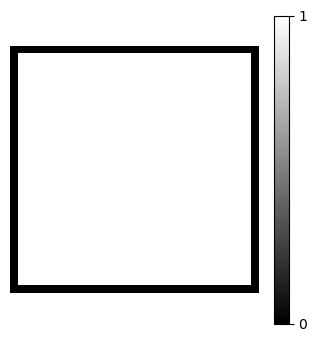

In [35]:
B = np.zeros((Nx+1, Ny+1), dtype=int)
B[1:-1, 1:-1] = 1
fig = plt.figure(figsize=(4, 4))
plt.imshow(B, cmap='gray')
plt.gca().axis('off')
plt.colorbar(ticks=[0, 1]);

Now find all the indices in the ravelled (vectorized) array `vec(B)` that equals 0.

In [36]:
bnds = np.where(B.ravel() == 0)[0]
print(bnds)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  61  62  92  93
 123 124 154 155 185 186 216 217 247 248 278 279 309 310 340 341 371 372
 402 403 433 434 464 465 495 496 526 527 557 558 588 589 619 620 650 651
 681 682 712 713 743 744 774 775 805 806 836 837 867 868 898 899 929 930
 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948
 949 950 951 952 953 954 955 956 957 958 959 960]


These are all the indices into `vec(U)` that correspond to a boundary. We need to set the value of $U$ to zero at all these indices. We do that by identing `A` such that each row with an index in `bnds` contains only zeros except the main diagonal which is set to 1.

In [37]:
A = A.tolil()
for i in bnds:
    A[i] = 0
    A[i, i] = 1
A = A.tocsr()

We also need to modify the right hand side $F$ such that $f_{ij}$ is zero for all points on the boundary. This is easy when `bnds` is available

In [38]:
b = F.ravel()
b[bnds] = 0

### Solve the problem

We have now set up the problem as

$$
Ax = b
$$

and all that is left is to solve the assembled problem using a sparse linear algebra solver

In [39]:
U = sparse.linalg.spsolve(A, b)
U = np.reshape(U, (Nx+1, Ny+1))

Plot the result

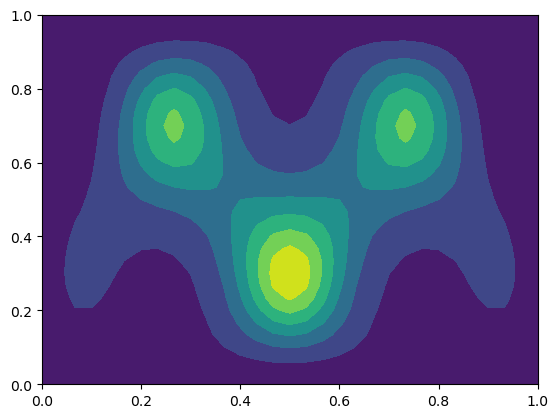

In [40]:
plt.contourf(xij, yij, U)

and check that the solution is close to the exact analytical solution

In [41]:
dx = Lx/Nx
dy = Ly/Ny
np.linalg.norm(dx*dy*(U - sp.lambdify((x, y), ue)(xij, yij)))

1.2935685467683658e-05

Voilà! The solution is correct. You should also verify that the solver works for a variety of spatial discretizations, especially when $N_x \ne N_y$.